In [1]:
import numpy as np
import math
import pandas as pd
import cv2
import os
import tqdm
from scipy.io import loadmat
from pdf2image import convert_from_path

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from PIL import Image
import pytesseract

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

#from utils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.layers import *

from keras.applications import MobileNetV2
from keras.applications import InceptionResNetV2

from keras.models import Model
from keras.models import model_from_json

from keras.models import load_model

In [18]:
# Converting pdf images from a folder to jpg images and save in different folder :

    """
    pdf directory = drg_21_8_pdf
    jpg directory = drg_21_8_jpg
    
    """

drg_directory = '/home/scar3crow/Downloads/drg_21_8_pdf'   
                                                        
drg_new_image = ['/home/scar3crow/Downloads/drg_21_8_pdf/{}'.format(i) for i in os.listdir(drg_directory)] # making the list
drg_new_image.sort() # Sorting the list

for i in range(len(drg_new_image)):
    
    pages = convert_from_path(drg_new_image[i], 300)
    

    drg_new_image_split = drg_new_image[i].split("/")
    drg_new_image_split = drg_new_image_split[-1].split(".")
    
    
    image_number = drg_new_image_split[0]
    
    for page in pages:
        
        i_path = '/home/scar3crow/Downloads/drg_21_8_jpg/' + image_number
    
        page.save(i_path, 'JPEG')


In [2]:
target_size = [608, 608]
target_w = 608 # target sizes of image in model input
target_h = 608 #target sizes of image in model input

grid_size = [19, 19]
grid_y_axis = 19  # each image is to be segmented to 17 x 17 grid
grid_x_axis = 19  # # each image is to be segmented to 17 x 17 grid

grid_stride = target_w / grid_x_axis  # grid cell width
grid_stride = target_h / grid_y_axis  # grid cell height

channels = 3
num_anchors = 3
class_num = 5 # vendor, invoice, inv_date, po, buyer
info = 5 + class_num    # pc, x, y, h, w, and class probabilities

categories = ['item'] # details of classes

In [3]:
# Making a list of image path

inv_directory = '/home/scar3crow/Downloads/drg_all'   
                                                        
inv_new_image = ['/home/scar3crow/Downloads/drg_all/{}'.format(i) for i in os.listdir(inv_directory)] # making the list
inv_new_image.sort() # Sorting the list

num_images = len(inv_new_image)

print('Number of images = ', num_images)


Number of images =  337


In [21]:
# Check sizes of exiting images & Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
image_sl = []
df_new = pd.DataFrame()

for i in range(len(inv_new_image)):
    image = cv2.imread(inv_new_image[i]) ## Loading image
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(inv_new_image[i])
        
row_values = pd.Series(rows)
col_values = pd.Series(columns)
image_num = pd.Series(image_sl)


df_new.insert(loc=0, column='image_serial', value=image_num)
df_new.insert(loc=1, column='rows', value=row_values)
df_new.insert(loc=2, column='columns', value=col_values)

df_new.tail(3)

,image_serial,rows,columns
178,/home/scar3crow/Downloads/drg_all/97.jpg,2479,3508
179,/home/scar3crow/Downloads/drg_all/98.jpg,2479,3508
180,/home/scar3crow/Downloads/drg_all/99.jpg,2479,3508


In [22]:
# Loading output of VGG Image Annotation tool and create a dataframe

r_new_data = pd.DataFrame()

r_new_data_1 = pd.read_csv('/home/scar3crow/Downloads/drg_via/via_drg_1.csv')
r_new_data_2 = pd.read_csv('/home/scar3crow/Downloads/drg_via/via_drg_2.csv')
r_new_data_3 = pd.read_csv('/home/scar3crow/Downloads/drg_via/via_drg_3.csv')
r_new_data_4 = pd.read_csv('/home/scar3crow/Downloads/drg_via/via_drg_4.csv')


r_new_data = pd.concat([r_new_data_1, r_new_data_2, r_new_data_3, r_new_data_4], axis = 0, ignore_index = True)

num_obj = r_new_data['region_count'][0] # number of objects in each photo
r_new_data.drop(r_new_data.columns[[1, 2, 3, 4]], axis=1, inplace=True) # reduce unnecessary columns

r_new_data = r_new_data[(r_new_data['#filename'] != '33.jpg') & (r_new_data['#filename'] != '20.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '74.jpg') & (r_new_data['#filename'] != '42.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '96.jpg') & (r_new_data['#filename'] != '28.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '47.jpg') & (r_new_data['#filename'] != '122.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '63.jpg') & (r_new_data['#filename'] != '97.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '56.jpg') & (r_new_data['#filename'] != '38.jpg')].reset_index(drop=True)
r_new_data = r_new_data[(r_new_data['#filename'] != '36.jpg') & (r_new_data['#filename'] != '99.jpg')].reset_index(drop=True)

r_new_data.sort_values(by=['#filename'], ascending=True) # Sorting based on image-id
num_images = r_new_data["#filename"].nunique() # Find out number of unique images

print('Number of unique images = ', num_images)
r_new_data.head(5)

Number of unique images =  109


,#filename,region_shape_attributes,region_attributes
0,1.jpg,"{""name"":""rect"",""x"":1886,""y"":1863,""width"":1457,...","{""text"":""item""}"
1,2.jpg,"{""name"":""rect"",""x"":2230,""y"":1615,""width"":1243,...","{""text"":""item""}"
2,3.jpg,"{""name"":""rect"",""x"":2143,""y"":1855,""width"":1200,...","{""text"":""item""}"
3,4.jpg,"{""name"":""rect"",""x"":2071,""y"":1840,""width"":1393,...","{""text"":""item""}"
4,5.jpg,"{""name"":""rect"",""x"":2224,""y"":1330,""width"":1140,...","{""text"":""item""}"


In [23]:
# Making a dataframe for Image_id, x, y, width, height, class, image_width and image_height

x = []
y = []
width = []
height = []
obj_class = []
i_width = []
i_height = []
img_path = []
img_index = []

for i in range(len(r_new_data)):
    
    r_size = r_new_data.values[i, 1][1:(len(r_new_data.values[i, 1])-1)]
    r_size_par = r_size.split(",")
    
    x.append(int("".join(filter(str.isdigit, r_size_par[1]))))
    y.append(int("".join(filter(str.isdigit, r_size_par[2]))))
    width.append(int("".join(filter(str.isdigit, r_size_par[3]))))
    height.append(int("".join(filter(str.isdigit, r_size_par[4]))))
    
    r_attribs = r_new_data.values[i, 2][1:(len(r_new_data.values[i, 2])-1)]
    r_attribs_par = r_attribs.split(':')[1]
    obj_class.append(r_attribs_par[1:(len(r_attribs_par)-1)])
    
    foto_id = r_new_data['#filename'][i]

    i_path = '/home/scar3crow/Downloads/drg_all/' + foto_id
    foto_index = int(df_new[df_new['image_serial'] == i_path].index[0])
    foto_width = df_new['columns'][foto_index]
    foto_height = df_new['rows'][foto_index]
    i_width.append(foto_width)
    i_height.append(foto_height)
    img_path.append(i_path)
    img_index.append(foto_index)
    
x_values = pd.Series(x)
y_values = pd.Series(y)
width_values = pd.Series(width)
height_values = pd.Series(height)
class_values = pd.Series(obj_class)
i_width_values = pd.Series(i_width)
i_height_values = pd.Series(i_height)
img_path_values = pd.Series(img_path)
img_index_values = pd.Series(img_index)

r_new_data.insert(loc=1, column='img_idx', value=img_index_values)
r_new_data.insert(loc=2, column='i_path', value=img_path_values)
r_new_data.insert(loc=3, column='x', value=x_values)
r_new_data.insert(loc=4, column='y', value=y_values)
r_new_data.insert(loc=5, column='width', value=width_values)
r_new_data.insert(loc=6, column='height', value=height_values)
r_new_data.insert(loc=7, column='obj_class', value=class_values)
r_new_data.insert(loc=8, column='img_wd', value=i_width_values)
r_new_data.insert(loc=9, column='img_ht', value=i_height_values)

r_new_data.drop(r_new_data.columns[[10, 11]], axis=1, inplace=True) # reduce unnecessary columns

r_new_data.rename({'#filename': 'img_id'}, axis=1, inplace=True) # changing column name

r_new_data[0:3]


,img_id,img_idx,i_path,x,y,width,height,obj_class,img_wd,img_ht
0,1.jpg,0,/home/scar3crow/Downloads/drg_all/1.jpg,1886,1863,1457,107,item,3509,2480
1,2.jpg,71,/home/scar3crow/Downloads/drg_all/2.jpg,2230,1615,1243,410,item,3509,2480
2,3.jpg,105,/home/scar3crow/Downloads/drg_all/3.jpg,2143,1855,1200,115,item,3509,2480


In [24]:
## Find out image with max boxes - to check whether annotation is correct :

max_box_image = r_new_data['img_id'].value_counts().max()
image_with_max_box =  r_new_data['img_id'].value_counts().idxmax()
print(image_with_max_box, 'with', max_box_image, 'boxes')

8.jpg with 1 boxes


In [25]:
def single_image_info(lines):
    
    ## lines will be a dataframe like, for i in range(num_images), lines = r_new_data[i*5:(i+1)*5]
    
    line_idx = lines.iat[0, 1]
    pic_path = lines.iat[0, 2]
    img_width = lines.iat[0, 8]
    img_height = lines.iat[0, 9]
    
    boxes = []
    labels = []
    for i in range(len(lines)):
        
        index_of = lines['obj_class'][i]
        label = categories.index(index_of)
        x_min, y_min, x_max, y_max = float(lines.iat[i,3]), float(lines.iat[i,4]), float(lines.iat[i,3]+lines.iat[i,5]), float(lines.iat[i,4]+lines.iat[i,6])
        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(label)
        
    boxes = np.asarray(boxes, np.float32)
    labels = np.asarray(labels, np.int64)
    
    return line_idx, pic_path, boxes, labels, img_width, img_height  ## boxes are in format xmin, ymin, xmax, ymax


In [26]:
## Creating the complete data set :

all_image_line = []
limit_lower = 0
limit_upper = 0
for i in range(num_images):
    image_line = []
    
    img = r_new_data['img_id'][limit_upper]
    kount = r_new_data['img_id'].value_counts()[img]
       
    limit_lower = limit_upper
    limit_upper = limit_lower + kount
    
    lines = r_new_data[limit_lower:limit_upper].reset_index(drop=True)
    """
    print('===================', i)
    print(img)
    print(limit_lower)
    print(limit_upper)
    """
    
    line_idx, pic_path, boxes, labels, img_width, img_height = single_image_info(lines)
    image_line.append(line_idx)
    image_line.append(pic_path)
    image_line.append(boxes)
    image_line.append(labels)
    image_line.append(img_width)
    image_line.append(img_height)
    all_image_line.append(image_line)
    
print(len(all_image_line))
print(all_image_line[3])   ##  boxes are in format xmin, ymin, xmax, ymax

109
[116, '/home/scar3crow/Downloads/drg_all/4.jpg', array([[2071., 1840., 3464., 2056.]], dtype=float32), array([0]), 3509, 2480]


In [40]:
img_id = 10
image_id = str(img_id) + '.jpg'
image_path = '/home/scar3crow/Downloads/drg_all/' + image_id
idx_crop = [i for i in range(len(all_image_line)) if all_image_line[i][1] == image_path]
idx_crop[0]

9

In [35]:
all_image_line[9][1]

'/home/scar3crow/Downloads/drg_all/10.jpg'

In [92]:
all_image_line

[[0,
  '/home/scar3crow/Downloads/drg_all/1.jpg',
  array([[1886., 1863., 3343., 1970.]], dtype=float32),
  array([0]),
  3509,
  2480],
 [71,
  '/home/scar3crow/Downloads/drg_all/2.jpg',
  array([[2230., 1615., 3473., 2025.]], dtype=float32),
  array([0]),
  3509,
  2480],
 [105,
  '/home/scar3crow/Downloads/drg_all/3.jpg',
  array([[2143., 1855., 3343., 1970.]], dtype=float32),
  array([0]),
  3509,
  2480],
 [116,
  '/home/scar3crow/Downloads/drg_all/4.jpg',
  array([[2071., 1840., 3464., 2056.]], dtype=float32),
  array([0]),
  3509,
  2480],
 [127,
  '/home/scar3crow/Downloads/drg_all/5.jpg',
  array([[2224., 1330., 3364., 2104.]], dtype=float32),
  array([0]),
  3509,
  2480],
 [138,
  '/home/scar3crow/Downloads/drg_all/6.jpg',
  array([[1893., 1800., 3347., 1969.]], dtype=float32),
  array([0]),
  3509,
  2480],
 [149,
  '/home/scar3crow/Downloads/drg_all/7.jpg',
  array([[2334., 1884., 3468., 2057.]], dtype=float32),
  array([0]),
  3509,
  2480],
 [160,
  '/home/scar3crow/Down

In [27]:
## Draw Box with sharpened image :

def draw_box_pred(img_id, box_list, label, target_size):
    
    image_id = str(img_id) + '.jpg'
#    print(image_id)
    image_path = '/home/scar3crow/Downloads/drg_all/' + image_id
#    print(image_path)

# find index of image in data frame :
    """
    image_list = r_new_data['img_id'].unique() # make a list of unique images
    idx = [i for i in range(len(image_list)) if image_list[i] == image_id] # find index of image
    """
# reading image and resizing as per target image :

    x = cv2.imread(image_path)
    x_ratio = target_size[1] / x.shape[1]
    y_ratio = target_size[0] / x.shape[0]

    xx = cv2.resize(x, (target_size[1], target_size[0]))
#    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#    xx = cv2.filter2D(xx, -1, kernel)
#    xx = unsharp_mask(xx)
    """
    print('======================', xx.max())
    print('======================', xx.min())
    
# slicing as per current image id

    r_new_data_slice = r_new_data.loc[r_new_data['img_id'].isin([image_list[idx[0]]])].reset_index(drop=True) 

    m = int(target_size[1] / grid_size[1])  # making x-scale for making grid
    n = int(target_size[0] / grid_size[0])  # making x-scale for making grid

    x_range = [0, m*1, m*2, m*3, m*4, m*5, m*6, m*7, m*8, m*9, m*10, m*11, m*12, m*13, m*14, m*15, m*16, m*17, m*18] 
    y_range = [0, n*1, n*2, n*3, n*4, n*5, n*6, n*7, n*8, n*9, n*10, n*11, n*12, n*13, n*14, n*15, n*16, n*17, n*18 ]

    for i in x_range:
            for j in y_range:
                cv2.rectangle(xx, (i, j), (i+32, j+32), 0, 2)
            
    for j in range(len(r_new_data_slice)):
    """
    for j in range(len(box_list)):
        
        xmin = int(box_list[j][0])
        ymin = int(box_list[j][1])
    
        xxmin = int(xmin * x_ratio)
        yymin = int(ymin * y_ratio)
 
        xmax = int(box_list[j][2])
        ymax = int(box_list[j][3])
    
        xxmax = int(xmax * x_ratio)
        yymax = int(ymax * y_ratio)
        
        obj_class = categories[int(label[j])]
    
#        print(xmin,ymin,xmax,ymax,xxmin,yymin,xxmax,yymax, obj_class)
        
        cv2.rectangle(x, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(x, obj_class, (xmin+10,ymin+10), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 0, 255), 2)
    
    
        cv2.rectangle(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
        cv2.putText(xx, obj_class, (xxmin+10,yymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
        cv2.line(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
        cv2.line(xx, (xxmin, yymax), (xxmax, yymin), (255, 0, 0), 2)
        
    
    x_pil = Image.fromarray(x)
#    display(x_pil)

    xx_pil = Image.fromarray(xx)
#    display(xx_pil)

    return(display(x_pil))   #, display(xx_pil))

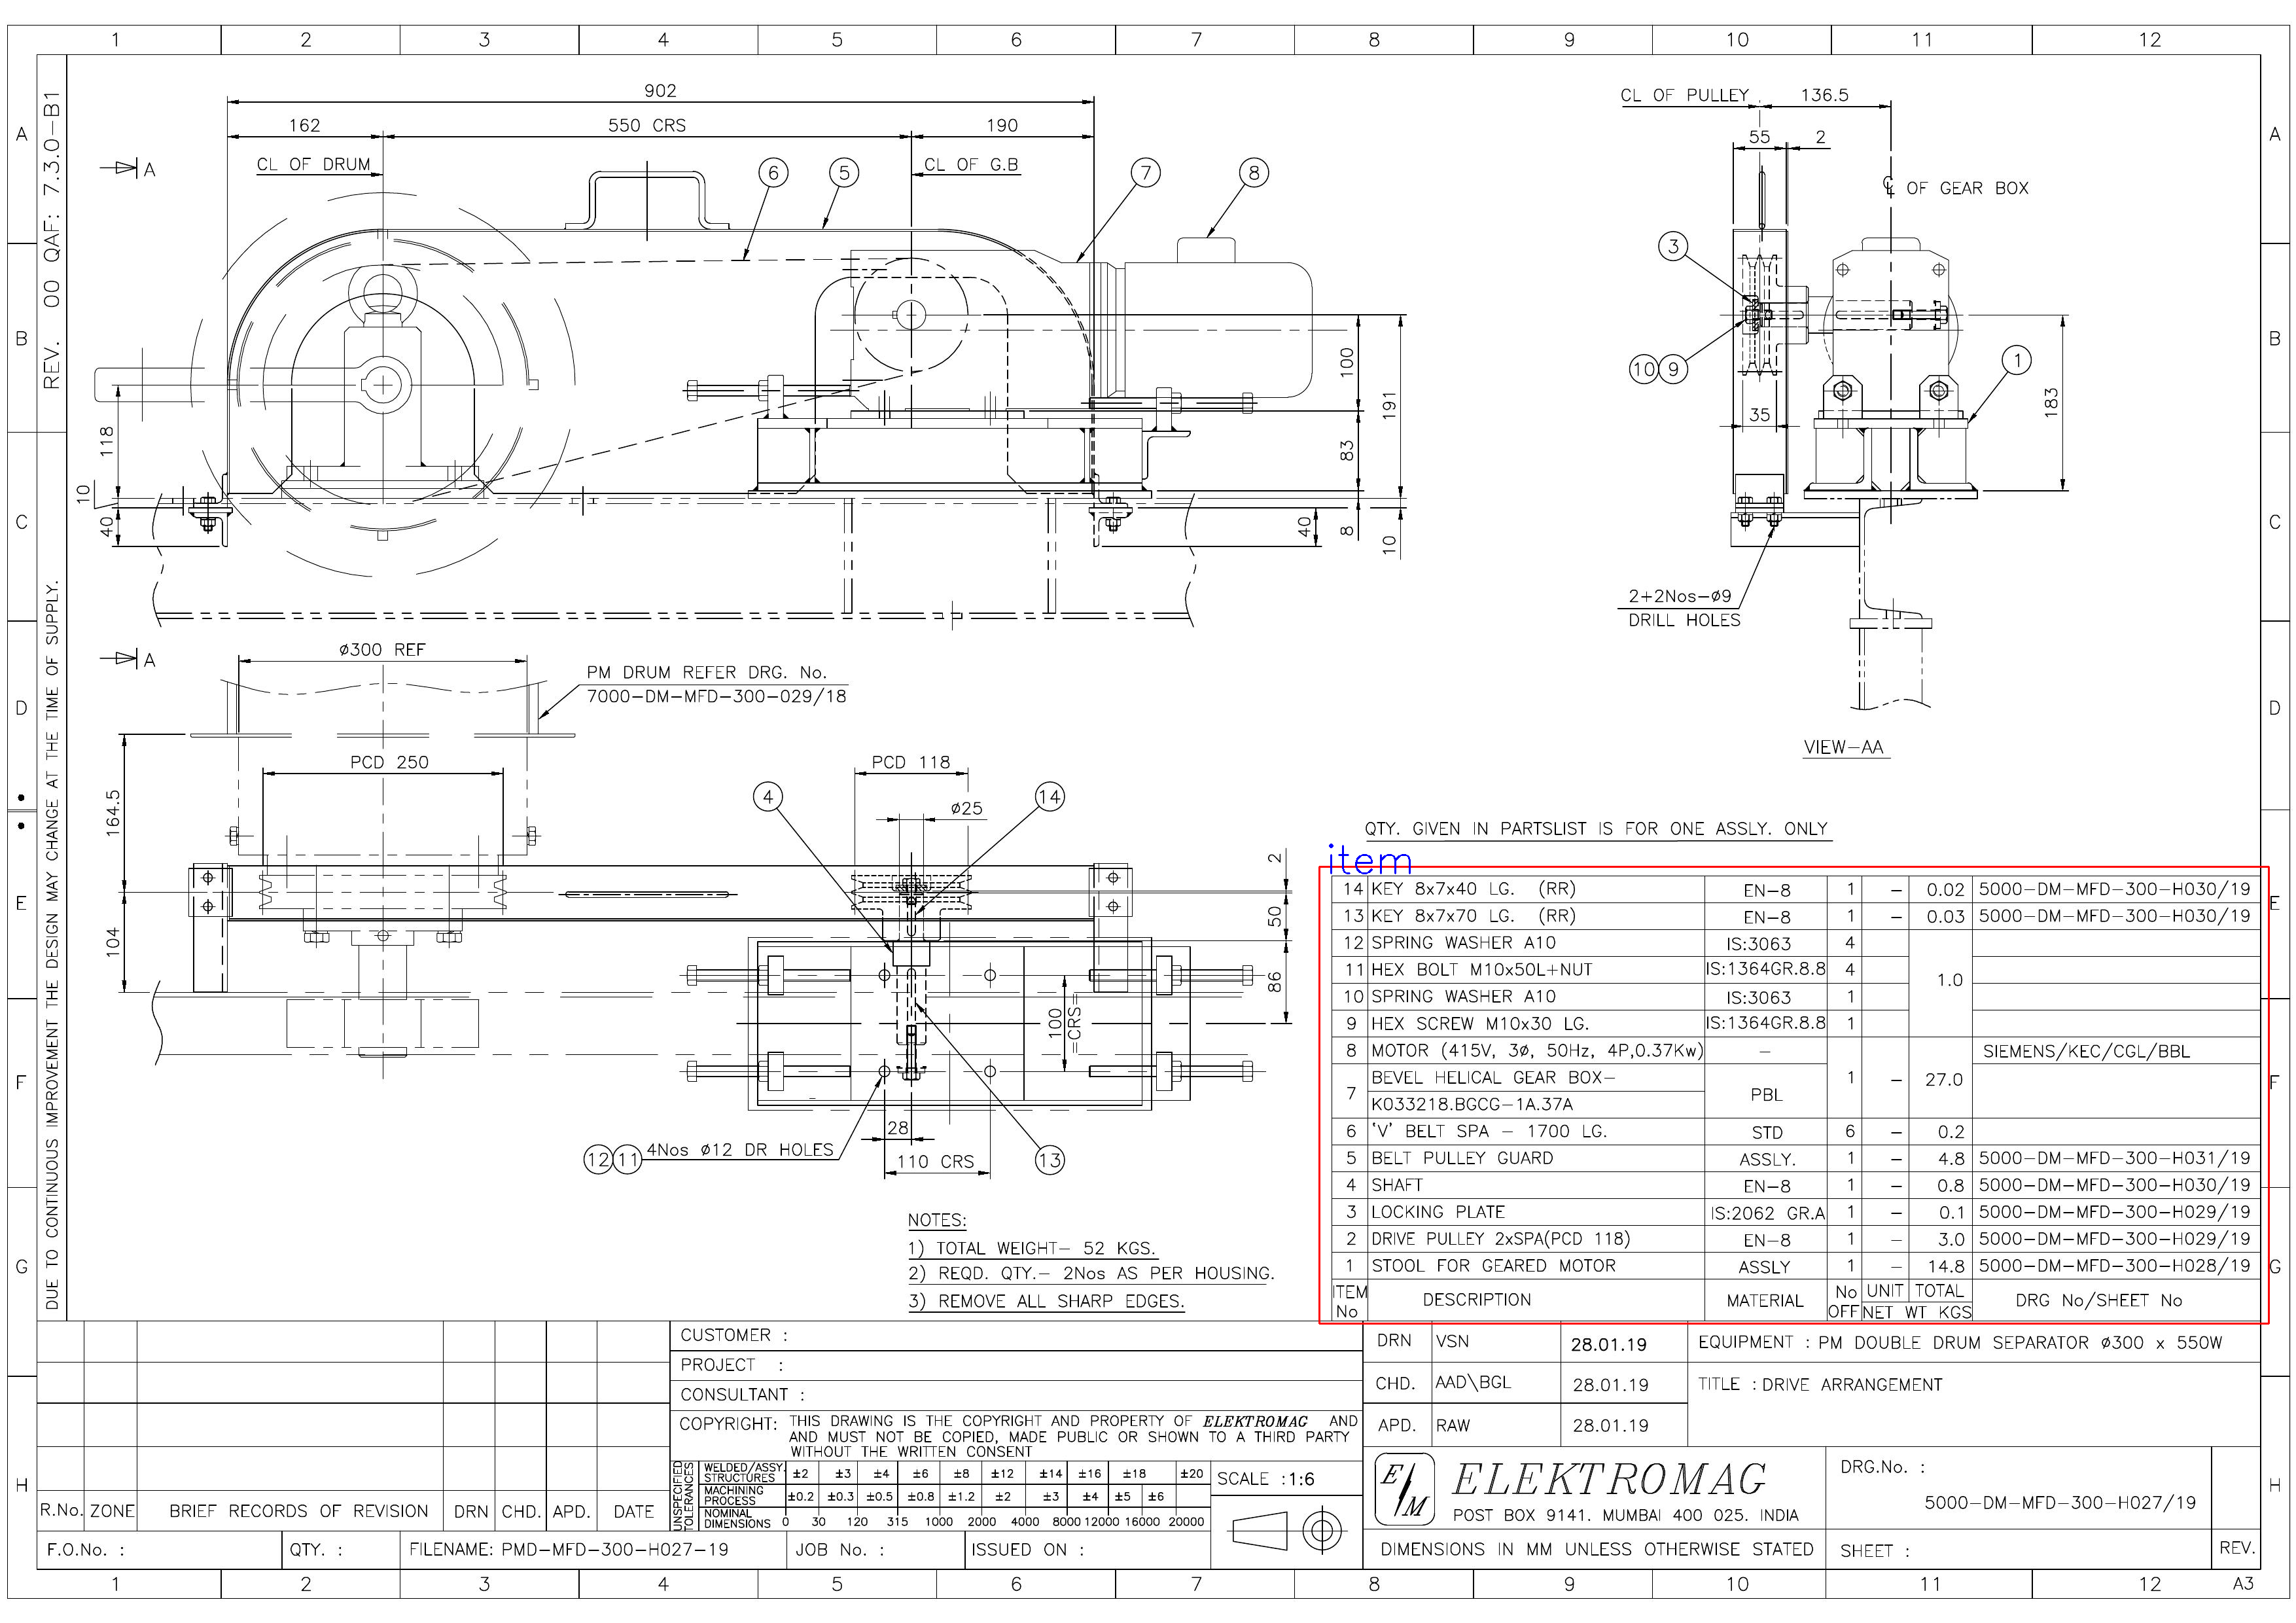

In [32]:
# Check whether box_list i.e. VGG image annotation is correct 

_,_,box_list,label,_,_ = all_image_line[9]

img_id = 10

draw_box_pred(img_id, box_list,label, target_size)


In [41]:
## Cropping the image or drawing to take out only the BOM area which is boxed :

def crop_bom(img_id):

    image_id = str(img_id) + '.jpg'
    image_path = '/home/scar3crow/Downloads/drg_all/' + image_id

    idx_crop = [i for i in range(len(all_image_line)) if all_image_line[i][1] == image_path] # find index of image       

    _,_,box_list,label,_,_ = all_image_line[idx_crop[0]]

    # print(box_list)  ## box_list is in format xmin, ymin, xmax, ymax

    x = cv2.imread(image_path)

    # By default OpenCV stores images in BGR format and since pytesseract assumes RGB format,
    # we need to convert from BGR to RGB format/mode:
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    xx_gray_list = []
    
    for i in range(len(box_list)):

        xx = x[int(box_list[i][1]):int(box_list[i][3]), int(box_list[i][0]):int(box_list[i][2])]
        xx_gray = cv2.cvtColor(xx,cv2.COLOR_BGR2GRAY)
        xx_gray_list.append(xx_gray)

    return xx_gray_list  ## this list is for more than 1 BOM in same drawing
    


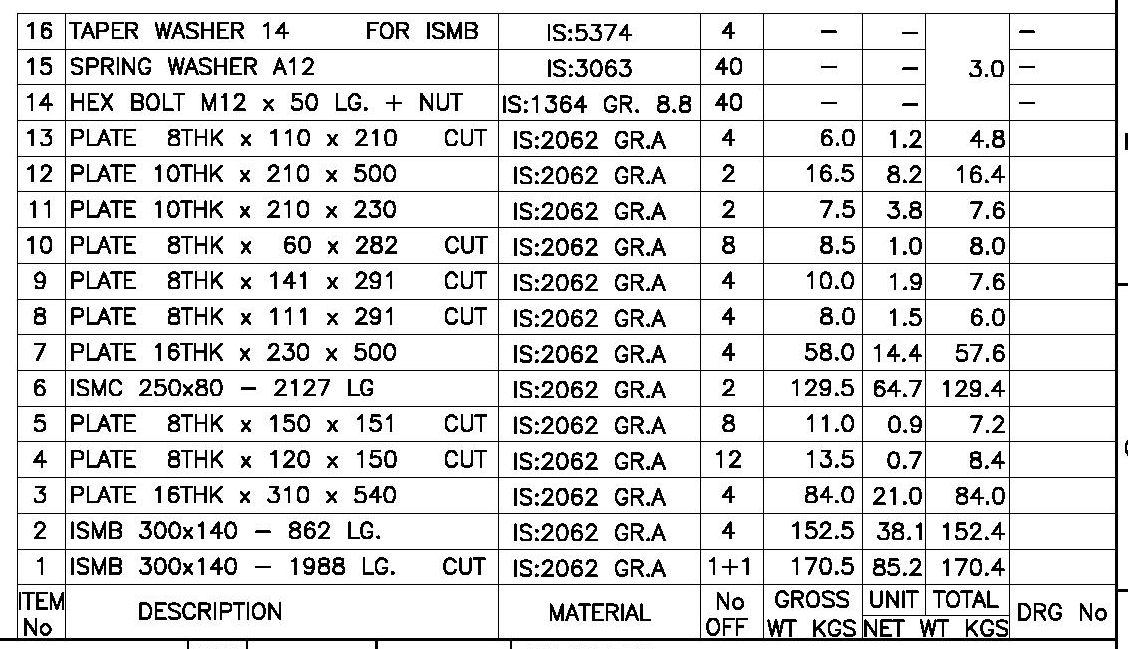

In [49]:
xx_gray_list = crop_bom(120)

for i in range(len(xx_gray_list)):

    xx_pil = Image.fromarray(xx_gray_list[i])

    display(xx_pil)

In [43]:
## Find out all individual boxes for subsequent text extraction :

def all_boxes(img_id):
    
    xx_gray_list = crop_bom(img_id)
    
    boxes_list = []
    
    for i in range(len(xx_gray_list)):
    
        ##thresholding the image to a binary image
        thresh,img_bin = cv2.threshold(xx_gray_list[i],0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        #inverting the image 
        img_bin_invert = 255-img_bin

        img_pil = Image.fromarray(img_bin_invert)
        """
        diplay(imgs_pil) 
        """
        # Length(width) of kernel as 100th of total width
        kernel_len = xx_gray_list[i].shape[1]//100

        # Defining a vertical kernel to detect all vertical lines of image 
        ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))

        # Defining a horizontal kernel to detect all horizontal lines of image
        hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

        #Use vertical kernel to detect and save the vertical lines in a jpg
        image_1 = cv2.erode(img_bin_invert, ver_kernel, iterations=3)
        vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

        #Use horizontal kernel to detect and save the horizontal lines in a jpg
        image_2 = cv2.erode(img_bin_invert, hor_kernel, iterations=3)
        horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

        # Combine horizontal and vertical lines in a new third image, with both having same weight.
        img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

        # A kernel of 2x2
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        # print('Final kernel = ', kernel)

        img_vh_d = cv2.dilate(img_vh, kernel, iterations=2)

        img_vh_d_pil = Image.fromarray(img_vh_d)
        
        display(img_vh_d_pil)
        
        # Defining the cell boxes

        contours, hierarchy = cv2.findContours(img_vh_d, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        boxes = np.zeros((len(contours), 4))

        for i in range(len(contours)):
    
            cnt = contours[i]
            x, y, w, h = cv2.boundingRect(cnt)
            boxes[i, 0] = x
            boxes[i, 1] = y
            boxes[i, 2] = w
            boxes[i, 3] = h

        # print(len(boxes))
        
        boxes_list.append(boxes)
    
    return boxes_list      ## ## in format x, y, w, h


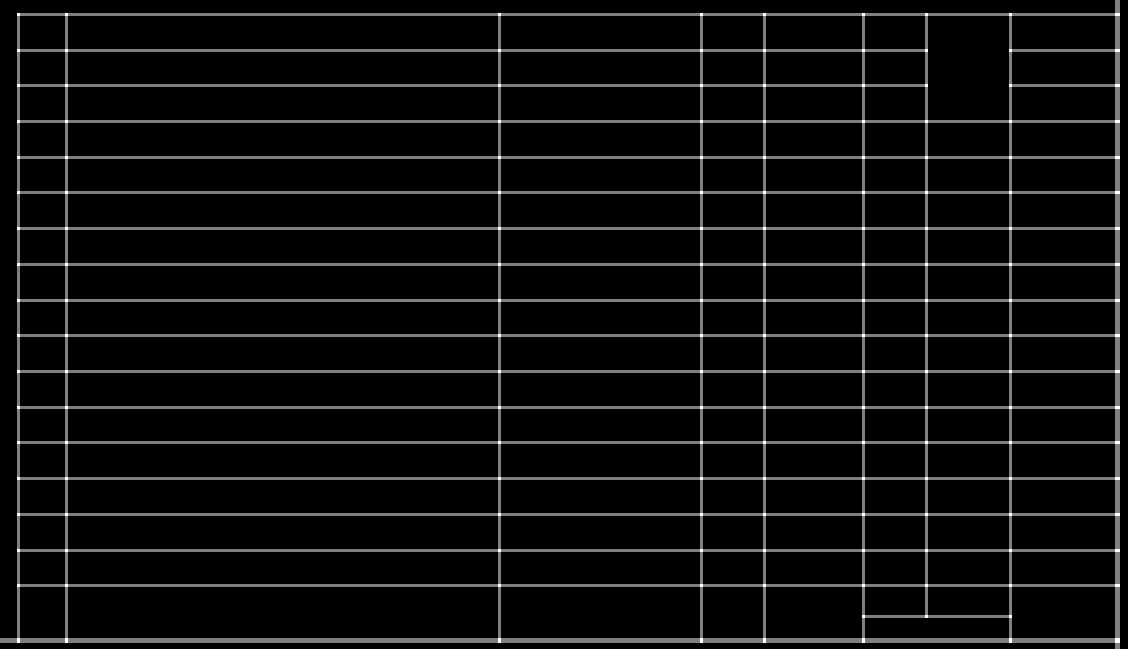

In [50]:
boxes_list = all_boxes(120)

In [45]:
## Take out header boxe and all other box info for all items separately :

def header_and_item(img_id):
    
    boxes_list = all_boxes(img_id)
    
    col_count_list = []
    header_boxes_list = []
    bom_boxes_list = []
    item_index_width_list = []
    
    for i in range(len(boxes_list)):
    
        boxes_1 = boxes_list[i][1:]   ## removing the line of full box i.e. removing 0th row

        ## Find number of columns i.e. max occurance of any y value :

        y_list = boxes_1[:, 1].tolist()   ## since boxes are in x,y,w,h format (output from cv2.boundingRect)

        col_count_array = np.bincount(y_list)  ## no. of occurances of each y-value
        col_count = col_count_array.max()  ## max. no. of occurances of y-value

        print('No. of columns = ', col_count)

        # Now fid the Header row. In drawings, header row is always at the bottom and cv2.boundingRect always starts,
        # after the 1st row which is box of complete BOM, from bottom right

        # So, y value of boxes[1] is the bottom_most-right_most (in this order) cell y value.

        y_bmrm_cell = boxes_1[0][1]

        num_col = y_list.count(y_bmrm_cell)   ## no. of occurances of y_bmrm_cell value

        if num_col == col_count:
    
            y_header_row = y_bmrm_cell
            item_index_width = boxes_1[col_count-1, 2]
            bom_boxes_1 = boxes_1[1:]   ## remove 1st header row for bom consideration
    
        else:
        
            y_next_cell = boxes_1[1][1]

            num_col = y_list.count(y_next_cell)

            if num_col == col_count:
    
                y_header_row = y_next_cell
                item_index_width = boxes_1[col_count, 2]
                bom_boxes_1 = boxes_1[2:]    ## remove 1st 2 rows for bom consideration

        header_boxes = boxes_1[boxes_1[:, 1] == y_header_row]
    
        bom_boxes = bom_boxes_1[bom_boxes_1[:, 1] != y_header_row]
        
        col_count_list.append(col_count)
        item_index_width_list.append(item_index_width)
        header_boxes_list.append(header_boxes)
        bom_boxes_list.append(bom_boxes)
    
    return col_count_list, item_index_width_list , header_boxes_list, bom_boxes_list  ## all boxes in x, y, w, h format


In [46]:
## Making the dataframe of BOM :

def bom_df(img_id):
    
    col_count_list, item_index_width_list, header_boxes_list, bom_boxes_list =  header_and_item(img_id)
    
    ## First find the header info - only one header box will be considered out of list :
    ## It is expected that all header info in one drawing should be same :
    
    
#    print(type(col_count_list), '====', col_count_list)
#    print(type(item_index_width_list), '====', item_index_width_list)
    
#    print('item index width = ', item_index_width_list)

    width_list = header_boxes_list[0][:,2]   # to find width of columns
    
    width_frequency = np.unique(width_list, return_counts=True)[1] # to check how many columns of same width
    
    
    
    print('width_frequency = ', width_frequency)
    
    print('width list = ', width_list)

    
    # Make a list of widths of all columns 
    
    all_width_list = bom_boxes_list[0][:,2].tolist() ## serialised from right to left
    row_count_array = np.bincount(all_width_list)  ## no. of occurances of each width-value
    row_count_apparent = row_count_array.max()
    
    row_count = row_count_apparent // np.max(width_frequency)
    
    print('Row count = ', row_count)
    
    
    aa = header_boxes_list[0].tolist()
    
    
    header_text = []

    for i in range(len(aa)):
    
        yy_gray = xx_gray_list[0][int(aa[i][1]-1):int(aa[i][1] + aa[i][3] - 1), int(aa[i][0]-1):int(aa[i][0] + aa[i][2] - 1)]
    
        thresh, yy_gray_1 = cv2.threshold(yy_gray, 0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
        text = pytesseract.image_to_string(yy_gray_1, config='--psm 6 --oem 2')

        header_text.append(text)
    
    serialised_header_text = header_text[::-1]
    
#    print(serialised_header_text)
    
    ## Now find all item or BOM info :
    
    num_item = 0
    bom_text = []
    item_count = 0
    
    for i in range(len(bom_boxes_list)):
        
#        print('bom_boxes_list = ', len(bom_boxes_list))
        
#        print(bom_boxes_list[i])
        
        item_count = item_count + np.count_nonzero(bom_boxes_list[i][:, 2] == item_index_width_list[i])
        print('No. of Items = ', item_count)
            
        y_unique = np.unique(bom_boxes_list[i][:,1])  # serialised from top to bottom
        y_unique = y_unique[::-1]        ## serialised from bottom to top
        
#        print(y_unique)

#        num_item = num_item + len(y_unique)

        for j in y_unique:
    
            bom_sub_text = []
            aa = np.ones((col_count_list[0], 4))
        
            # bb = bom_boxes_list[i]
    
            bb = bom_boxes_list[i][bom_boxes_list[i][:, 1] == j]
        
#            print(bb)
#            print('==================================================')
            
            for k in range(len(width_list)):
                for l in range(len(bb)):
                    if bb[l][2] == width_list[k]:
                        aa[k, :] = bb[l, :]
                        
#            print(aa)
#            print('=======================================================')
#            print('=======================================================')

            
            for k in range(len(aa)):
    
#        thresh, xx_gray_1 = cv2.threshold(xx_gray,0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
                yy_gray = xx_gray_list[i][int(aa[k][1]-1):int(aa[k][1] + aa[k][3] - 1), int(aa[k][0]-1):int(aa[k][0] + aa[k][2] - 1)]
        
                text = pytesseract.image_to_string(yy_gray, config='--psm 6 --oem 3')
            
#                print('k value = ', k, 'text value = ', text)
        
                bom_sub_text.append(text)
    
            bom_sub_text_rev = bom_sub_text[::-1]
#            print('length of sub_text = ', len(bom_sub_text_rev))
            bom_text.append(bom_sub_text_rev)
            
        
            
        #Creating a dataframe of the generated OCR list
    arr = np.array(bom_text)
             
    dataframe = pd.DataFrame(arr.reshape(row_count, col_count_list[0]), columns = serialised_header_text)
    
    return dataframe


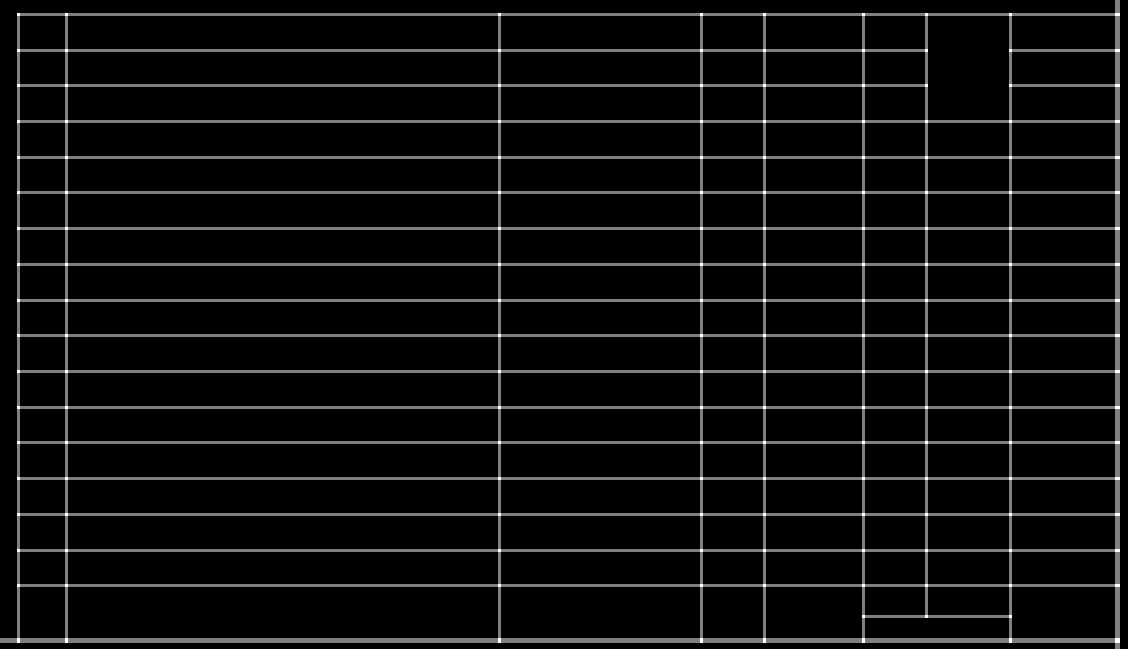

No. of columns =  8
width_frequency =  [1 2 1 1 1 1 1]
width list =  [105.  83.  62.  98.  62. 201. 432.  47.]
Row count =  16
No. of Items =  16


,ITEM No,DESCRIPTION,MATERIAL,No OFF,GROSS WT KGS,UNIT,TOTAL,DRG No
0,1,ISMB 300x140 — 1988 LG. CUT,15:2062 GRA,1+1,170.5,1+1,170.4,
1,2,ISMB 300x140 — 862 LG.,1S:2062 GRA,4,152.5,4,152.4,| |
2,3,PLATE 16THK x 310 x 540,15:2062 GRA,4,84.0,4,84.0,1 _ _ _
3,4,PLATE BTHK x 120 x 150 _ CUT,15:2062 GRA,12,13.5,12,8.4,| |
4,5,PLATE BTHK x 150 x 151 CUT,18:2062 GRA,8,11.0,8,7.2,
5,6,ISMC 250x80 — 2127 LG,15:2062 GRA,2,129.5,2,129.4,[ 0
6,7,PLATE 16THK x 230 x 500,1S:2062 GRA,4,58.0,4,57.6,
7,8,PLATE BTHK x 111 x 291 CUT,15:2062 GRA,4,8.0,4,6.0,
8,9,PLATE BTHK x 141 x 291 CUT,15:2062 GRA,4,10.0,4,7.6,e
9,10,PLATE BTHK x 60 x 282 CUT,1S:2062 GRA,8,8.5,8,8.0,


In [51]:
df = bom_df(120)

df.head(20)

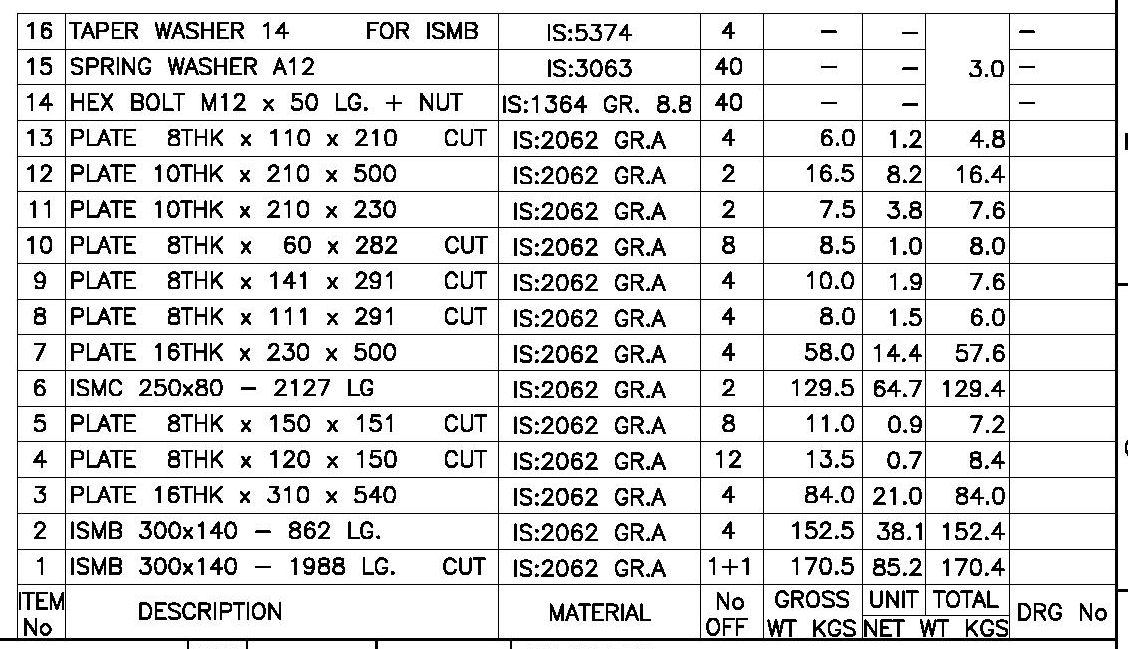

In [52]:
xx_gray_list = crop_bom(120)

for i in range(len(xx_gray_list)):

    xx_pil = Image.fromarray(xx_gray_list[i])

    display(xx_pil)